<a href="https://colab.research.google.com/github/YushanH/NN-parameters-vs-accuracy/blob/master/HawkesN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data (California/LA county)

[    1     7    11    13    14    14    20    20    29    29    40    53
    69    94   144   190   231   292   351   409   536   662   799  1216
  1465  1804  2136  2474  3011  3518  4045  4566  5277  5940  6360  6910
  7530  7955  8430  8873  9192  9420 10047 10496 10854 11391 12021 12341
 13816 15140 16435 17508 18517 19107 19528 20417 20976 22485 23182 24215
 24894 25662 26217 27815 28644 29427 30296 31197 31677 32258 33180 34428
 35329 36259 37303 37974 38451 39573 40857 42037 43052 44055 44988 46018
 47822 48700 49774 51562 53651 54996 55968 57118 58234 59650 61045]
first day: 3/3/20
last day: 6/2/20
Infected: [    1     7    11    13    14    14    20    20    29    29    40    53
    69    94   144   190   231   292   351   409   536   662   799  1216
  1465  1804  2136  2474  3011  3518  4045  4566  5277  5940  6360  6910
  7530  7955  8430  8873  9192  9420 10047 10496 10854 11391 12021 12341
 13816 15140 16435 17508 18517 19107 19528 20417 20976 22485 23182 24215
 24894 2566

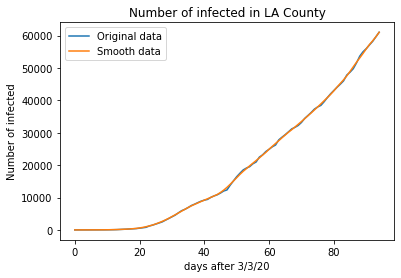

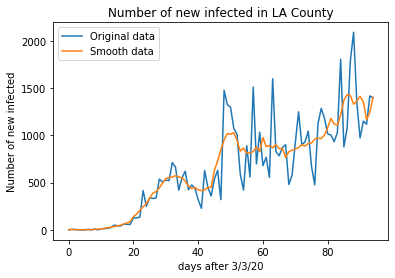

In [0]:
import json
import urllib
import matplotlib as plt
import numpy as np
import pandas
from pandas import DataFrame as DF
import matplotlib.pyplot as plt
# Load California Data from covidtracking.com

# url = "https://covidtracking.com/api/v1/states/daily.json"
# response = urllib.request.urlopen(url)
# data = json.loads(response.read())
# data_df = DF(data)
# data_CA_df = data_df[data_df.state=='CA'].sort_index(ascending=False, axis=0)

# infected = np.array(data_CA_df.positive, dtype=np.int64)
# new_infected = np.array(data_CA_df.positiveIncrease, dtype=np.int64)
# date = np.array(data_CA_df.date, dtype=np.int64)

url = "https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv"
data = pandas.io.parsers.read_csv(url)
#print(data)
data_LA = data.loc[data["County Name"] == "Los Angeles County"]
#print(data_LA)
date = data_LA.columns.tolist()[45:]
infected = np.array(data_LA.iloc[0,45:], dtype=np.int64)
#print(infected)
# Smoothing data for 7-day average
infected_smooth = np.zeros(infected.shape, dtype=np.int64)


num_days = len(infected)
for i in range(num_days):
  if i-3 >= 0 and i+3 <= num_days-1:
    infected_smooth[i] = int(sum(infected[i-3:i+4])/7)
  else:
    avg_range = min(i, num_days-1-i)
    infected_smooth[i] = int(sum(infected[i-avg_range: i+avg_range+1])/(2*avg_range+1))

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
print(f"first day: {date[0]}")
print(f"last day: {date[-4]}")
print("Infected:", infected)


new_infected_smooth = np.diff(infected_smooth)
new_infected_smooth = np.insert(new_infected_smooth, 0, 1)
new_infected = np.diff(infected)
new_infected = np.insert(new_infected, 0, 1)
print("New Infected:", new_infected)

plt.plot(infected, label = "Original data")
plt.plot(infected_smooth, label = "Smooth data")
plt.legend(loc = 'best')
plt.xlabel(f"days after {date[0]}")
plt.ylabel("Number of infected")
plt.title("Number of infected in LA County")
plt.show()

plt.plot(new_infected, label = "Original data")
plt.plot(new_infected_smooth, label = "Smooth data")
plt.legend(loc = 'best')
plt.xlabel(f"days after {date[0]}")
plt.ylabel("Number of new infected")
plt.title("Number of new infected in LA County")
plt.show()

# Dump the last three days
infected = infected_smooth[:-3]
new_infected = new_infected_smooth[:-3]

# HawkesN **Formulas**:

- Kernel: $\phi(t;k,\theta) = k\theta e^{-\theta t}$  
- Intensity: $\lambda = (1-Nt/N)(\mu+\sum_{t_j<t} \phi(t-t_j))$   
Here we assume events recorded at t happened right before t, therefore included in sum , $\mu = 0$
- Log-Likelihood: $L(k,\theta,N; data) = \sum_{j=1}^n log(\lambda(t_j)) - \int_0^{T} \lambda(s)ds$  
$\int_0^{T} \lambda(s)ds = \sum_{t=0}^{T-1} (1-N_t/N)\sum_{s=0}^{t-1}N(s)\int_{t}^{t+1}\phi(t-s)ds$  
Where $N(s)$ is the number of events happened at time s

In [0]:
#from math import exp, log
from tqdm import tqdm
# Build Hawkes model

def kernel(t, k, theta):
  return k * theta * np.exp(-theta * t)

# kernel_vectorized = np.vectorize(kernel, excluded=["k", "theta"])
def kernel_integral(t, k, theta):
  #return k * np.exp(-theta * t)
  return k * np.exp(-theta * t) - k * np.exp(-theta * (t+1))#ugly hack

def intensity(t, N, k, theta, new_infected, infected, mu=0):
  """lambda = (1-Nt/N)(mu+sum_tj<t kernel(t-tj)), where tj are individual events"""
  #assert(type(t) == int)
  #total = 0
  date_vector = np.arange(t, -1, -1) #[t,..., 0]
  #kernel_vector = kernel_vectorized(date_vector)
  kernel_vector = kernel(date_vector, k, theta)
  return (1-infected[t]/N) * np.inner(kernel_vector, new_infected[:t+1]) 

def intensity_vec (t, N, k, theta, new_infected, infected, mu=0):
  """lambda = (1-Nt/N)(mu+sum_tj<t kernel(t-tj)), where tj are individual events"""
  T = np.max(t)
  date_vector = np.arange(T+1) #[t+1,..., 0+1]
  #kernel_vector = kernel_vectorized(date_vector)
  kernel_vector = kernel(date_vector, k, theta)
  #kernel_vector[0]=1E-2
  cvec = np.convolve(kernel_vector, new_infected)
  return (1-infected[t]/N) * cvec[t]

#log_int_vec = np.vectorize(intensity, excluded = ["t","k","theta","new_infected","infected","mu"])
def log_likelihood(N, k, theta, infected, new_infected, mu=0):
  """Returns likelihood of data:[t1,t2,...,tn] occuring given parameters (k, theta, N)"""
  t_end = len(infected)
  likelihood = 0
  time_vec = np.arange(t_end)
  #kernel_vec = np.vectorize(lambda t: kernel(t,k,theta),otypes=[float])
  #log_int_vec = lambda t: np.log(intensity(t,N,k,theta,new_infected,infected,mu))
  #log_int_vec = np.vectorize(log_int_vec)
  likelihood += np.inner(new_infected, np.log(intensity_vec (time_vec, N, k, theta, new_infected, infected)))#log_int_vec(time_vec))
  for i in range(t_end-1):
    #likelihood += new_infected[i]*np.log(intensity(i, N, k, theta,new_infected, infected, mu))
    # Have not added mu here
    #time period (i,i+1)
    likelihood -= (1-infected[i]/N) * np.inner(new_infected[:i+1],kernel_integral(np.arange(i,-1,-1), k, theta))
    #for j in range(i+1):
      #likelihood -= (1-infected[i]/N)*new_infected[j]*(kernel_integral(i+1-j,k,theta) - kernel_integral(i-j,k,theta))
  likelihood *= (N>0)
  return likelihood

# Aliasing L -> loglikelihood
L = log_likelihood


def fitted_parameters(num_N, num_k, num_theta, bounds, test_inf, test_inf_new):
  # Sampling k,theta,N
  N_lb, N_ub, k_lb, k_ub, theta_lb, theta_ub = bounds
  N_list = np.linspace(N_lb, N_ub, num_N)
  #print(N_list)
  k_list = np.linspace(k_lb, k_ub, num_k)
  #print(k_list)
  theta_list = np.linspace(theta_lb, theta_ub, num_theta)

  mesh = np.array(np.meshgrid(N_list, k_list, theta_list)).T.reshape(-1,3)
  L_vec = lambda x: L(x[0], x[1], x[2], test_inf,test_inf_new)
  sim_lkhd = np.apply_along_axis(L_vec, 1,mesh)
  
  # sim_lkhd = np.zeros((num_N, num_k, num_theta))
  # for i in tqdm(range(num_N)):
  #   for j in range(num_k):
  #     for p in range(num_theta): 
  #       N,k,theta = N_list[i], k_list[j], theta_list[p]
  #       sim_lkhd[i,j,p] = L(N,k,theta, infected, new_infected)
  
  i = sim_lkhd.argmax()
  return mesh[i][0], mesh[i][1], mesh[i][2]

In [0]:
# Create test data
validation_time = 15
test_inf, test_new_inf = infected[:-validation_time], new_infected[:-validation_time]

In [0]:
# Fit parameters
import time
tic = time.time()
N,k,theta = fitted_parameters(10,200,5,(max(infected)+10000, 10000000, 0.5,2,0.01,5),test_inf,test_new_inf)
print(f"\nN = {N}, k = {k}, theta = {theta}")
print(f"Elapsed time = {round(time.time()-tic, 2)}s")
#14.6s


N = 10000000.0, k = 1.0276381909547738, theta = 5.0
Elapsed time = 14.41s


In [0]:

# for n in np.linspace(100000,10000000,40):
#   print(n,L(n, 1.0305128205128204, 10.0, test_inf, test_new_inf))
# for k in np.linspace(0.1,5,100):
#    print(k,L(n, k, theta, test_inf, test_new_inf))
# for theta in np.linspace(0.1,5,100):
#   print(theta,L(100000, 1.03, theta, test_inf, test_new_inf))
#print(L(10000000.0, 1.0305128205128204, 10.0, test_inf, test_new_inf))

print(f"\nN = {N}, k = {k}, theta = {theta}")
n = test_inf[-1]
T = len(test_inf)

result = n*(n-1)/2
for t in range(T-1):
  a = 0
  for r in range(t,T-1):
    a += test_inf[r]*kernel_integral(r-t,k,theta)
  result -= a*test_new_inf[t]
print("dL/dN >= 1/N^2*", round(result))

# for k in np.linspace(1,1.5,20):
#   for theta in np.linspace(0.1,10,10):
#     result = n*(n-1)/2
#     for t in range(T-1):
#       a = 0
#       for r in range(t,T-1):
#         a += test_inf[r]*kernel_integral(r-t,k,theta)
#       result -= a*test_new_inf[t]
#     if result < 0:
#         print(k,theta,result)


N = 10000000.0, k = 1.0276381909547738, theta = 5.0
dL/dN >= 1/N^2* 1500941.0


Predicted  Ground Truth
892 		 900
914 		 885
935 		 913
958 		 918
980 		 959
1003 		 970
1027 		 965
1050 		 1002
1075 		 1081
1100 		 1178
1125 		 1120
1151 		 1106
1177 		 1215
1203 		 1371
1230 		 1430


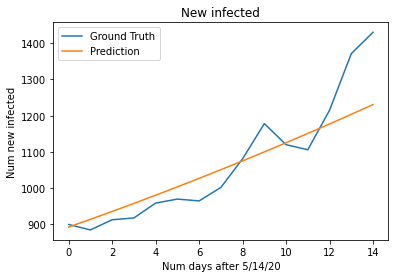

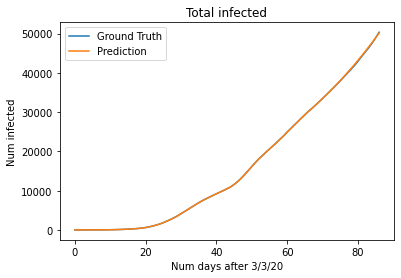

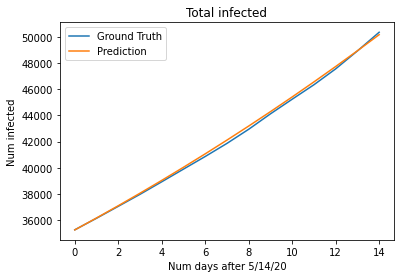

In [0]:
# Validation
def simulation(N, k, theta, test_inf, test_new_inf, validation_time):
  """Given infected & new infected up to now, predict for days(# = validation_time)"""
  time = len(test_inf)-1  # The endpoint time
  for t in range(time, time+validation_time):
    new_case = 0
    #lambda_t = (1-Nt/N)(mu+\sum tj<t kernel(t-tj))
    for i in range(t+1):
      # contribution from infection = \int_{t}^{t+1} lambda(t)
      new_case += test_new_inf[i]*kernel_integral(t-i,k,theta)
    new_case *= 1-test_inf[t]/N
    test_inf = np.append(test_inf, new_case + test_inf[-1])
    test_new_inf = np.append(test_new_inf, new_case)
  return test_inf, test_new_inf

predicted_inf, predicted_new_inf = simulation(N,k,theta, test_inf,test_new_inf,validation_time)
test_n = len(test_inf)
fitted_inf, fitted_new_inf = simulation(N,k,theta,test_inf[0:test_n-validation_time], test_new_inf[0:test_n-validation_time], validation_time*2)

print("Predicted  Ground Truth")
for i in range(len(predicted_new_inf)-validation_time, len(predicted_new_inf)):
  print(int(predicted_new_inf[i]), "\t\t", new_infected[i])
#plt.plot(fitted_new_inf, label = "Fitted")
plt.plot(new_infected[-validation_time:], label = "Ground Truth")
plt.plot(predicted_new_inf[-validation_time:], label = "Prediction")
plt.legend(loc = "best")
plt.xlabel(f"Num days after {date[len(infected)-validation_time]}")
plt.ylabel("Num new infected")
plt.title("New infected")
plt.show()

plt.plot(infected, label = "Ground Truth")
plt.plot(predicted_inf, label = "Prediction")
#plt.plot(fitted_inf, label = "Fitted")
plt.xlabel(f"Num days after {date[0]}")
plt.ylabel("Num infected")
plt.legend(loc = "best")
plt.title("Total infected")
plt.show()

plt.plot(infected[-validation_time:], label = "Ground Truth")
plt.plot(predicted_inf[-validation_time:], label = "Prediction")
#plt.plot(fitted_inf, label = "Fitted")
plt.xlabel(f"Num days after {date[len(infected)-validation_time]}")
plt.ylabel("Num infected")
plt.legend(loc = "best")
plt.title("Total infected")
plt.show()


# Second Approach, Distributed data

In [0]:
end_time = 15
infected2 = infected[:end_time]
new_infected2 = new_infected[:end_time]

timepoints = np.zeros(int(infected2[-1]),dtype=np.float64)
for i in range(1,end_time):
  for j in range(new_infected2[i]):
    timepoints[infected2[i-1]+j] = i-1+(j+1)/new_infected2[i]
#print(timepoints)
timediff = np.diff(timepoints)
#print(timediff)

print(infected2)
print(new_infected2)
print(new_infected[:30])

[  1   6   9  11  14  17  19  23  29  37  47  65  88 117 153]
[ 1  5  3  2  3  3  2  4  6  8 10 18 23 29 36]
[  1   5   3   2   3   3   2   4   6   8  10  18  23  29  36  42  49  63
  74  87 141 167 208 247 277 335 389 404 443 496]


In [0]:
# Second approach, distinct data points

def kernel_integral(t, k, theta):
  #return k * np.exp(-theta * t)
  return k * np.exp(-theta * t) - k * np.exp(-theta * (t+1))#ugly hack
#log_int_vec = np.vectorize(intensity, excluded = ["t","k","theta","new_infected","infected","mu"])
def log_likelihood_2(k, theta, timepoints,timediff):
  t_end = int(timepoints[-1])
  num_points = len(timepoints)
  # Compute \sum log(\lambda(t_j))
  lambda_old = k*theta
  likelihood = np.log(lambda_old)
  likelihood -= k*(1-np.exp(-timediff[0]))
  for i in range(1,num_points-1):
    lambda_old = (lambda_old+k*theta)*(np.exp(-theta*timediff[i-1]))
    likelihood += np.log(lambda_old)
    likelihood -= (1-np.exp(-theta*timediff[i]))*(lambda_old/theta+k)
  lambda_old = (lambda_old+k*theta)*(np.exp(-theta*timediff[num_points-2]))
  likelihood += np.log(lambda_old)
  return likelihood

# Aliasing L -> loglikelihood
L2 = log_likelihood_2


def fitted_parameters2(num_k, num_theta, bounds, timepoints, timediff):
  # Sampling k,theta,N
  k_lb, k_ub, theta_lb, theta_ub = bounds
  k_list = np.linspace(k_lb, k_ub, num_k)
  #print(k_list)
  theta_list = np.linspace(theta_lb, theta_ub, num_theta)

  mesh = np.array(np.meshgrid(k_list, theta_list)).T.reshape(-1,2)
  L_vec = lambda x: L2(x[0], x[1], timepoints, timediff)
  sim_lkhd = np.apply_along_axis(L_vec, 1,mesh)
  
  # sim_lkhd = np.zeros((num_N, num_k, num_theta))
  # for i in tqdm(range(num_N)):
  #   for j in range(num_k):
  #     for p in range(num_theta): 
  #       N,k,theta = N_list[i], k_list[j], theta_list[p]
  #       sim_lkhd[i,j,p] = L(N,k,theta, infected, new_infected)
  
  i = sim_lkhd.argmax()
  return mesh[i][0], mesh[i][1]

In [0]:
k,theta = fitted_parameters2(200,30,(0.5,2,0.01,1), timepoints,timediff)
print(f"k = {k}, theta = {theta}")



k = 1.6457286432160803, theta = 0.41965517241379313


In [0]:
print(L2(k,theta, timepoints, timediff))
print(L2(1.3,theta, timepoints, timediff))

268.0800121863149
264.2092610507829


[  1   6   9  11  14  17  19  23  29  37  47  65  88 117 153]
[ 1  5  3  2  3  3  2  4  6  8 10 18 23 29 36]
41.6807001827277
50.90441592727875
62.16911355373803
75.92632523684011
92.72743411299406
Predicted  Ground Truth
29 		 29
36 		 36
41 		 42
50 		 49
62 		 63


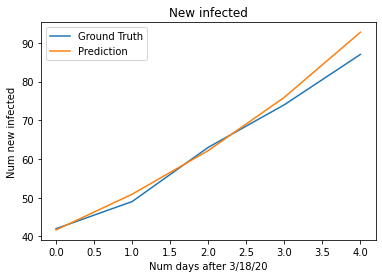

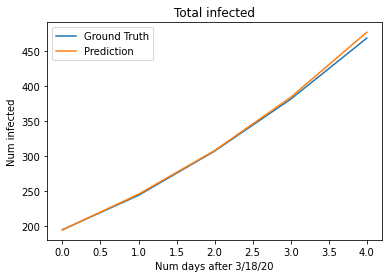

In [0]:
# Fit parameters and predict

validation_time = 5
def simulation(N, k, theta, test_inf, test_new_inf, validation_time):
  """Given infected & new infected up to now, predict for days(# = validation_time)"""
  time = len(test_inf)-1  # The endpoint time
  print(test_inf)
  print(test_new_inf)
  for t in range(time, time+validation_time):
    new_case = 0
    #lambda_t = (1-Nt/N)(mu+\sum tj<t kernel(t-tj))
    for i in range(t+1):
      # contribution from infection = \int_{t}^{t+1} lambda(t)
      new_case += test_new_inf[i]*kernel_integral(t-i,k,theta)
    new_case *= 1-test_inf[t]/N
    print(new_case)
    test_inf = np.append(test_inf, new_case + test_inf[-1])
    test_new_inf = np.append(test_new_inf, new_case)
  return test_inf, test_new_inf

predicted_inf, predicted_new_inf = simulation(10**7,k,theta, infected2,new_infected2,validation_time)
n = len(infected2)



print("Predicted  Ground Truth")
for i in range(n, len(predicted_new_inf)):
  print(int(predicted_new_inf[i-2]), "\t\t", new_infected[i-2])
plt.plot(new_infected[n:n+validation_time], label = "Ground Truth")
plt.plot(predicted_new_inf[n:], label = "Prediction")
#plt.plot(fitted_new_inf, label = "Fitted")

plt.legend(loc = "best")
plt.xlabel(f"Num days after {date[n]}")
plt.ylabel("Num new infected")
plt.title("New infected")
plt.show()

plt.plot(infected[n:n+validation_time], label = "Ground Truth")
plt.plot(predicted_inf[n:], label = "Prediction")
#plt.plot(fitted_inf, label = "Fitted")
plt.xlabel(f"Num days after {date[n]}")
plt.ylabel("Num infected")
plt.legend(loc = "best")
plt.title("Total infected")
plt.show()

# Gibbs with Metropolis Hastings sampling

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tq

from numpy.random import rand, randn

class Gibbs_with_Metropolis_Hastings:
    def __init__ (self, initial_value, distribution, total_num_sample, is_log=False):
        self.distribution = distribution
        self.current = np.asarray(initial_value)
        self.variable_count, self.sample_count = self.current.shape
        self.end = total_num_sample
        self.is_log = is_log

    def variables_iter (self):
        for i in range(self.variable_count):
            yield self.current[i, :]

    def random_perturb (self):
        return randn(self.sample_count)

    def random_uniform (self):
        return rand(self.sample_count)

    def __next__ (self):
        for variable in self.variables_iter():
            current_distribution = self.distribution(self.current)  #current pdf
            perturbation = self.random_perturb()
            variable += perturbation
            proposed_distribution = self.distribution(self.current) #new pdf
            if self.is_log:
                criterion = proposed_distribution - current_distribution
                acceptance = (np.log(self.random_uniform()) < criterion)
            else:
                criterion = proposed_distribution / current_distribution
                acceptance = (self.random_uniform() < criterion)
            variable -= perturbation
            variable += perturbation * acceptance

    def __iter__ (self):
        for i in range(self.end):
            self.__next__()
            yield self.current

    def gen (self, gap=1, start=1, use_tqdm=False):
        irange = range(self.end * gap + start)
        if use_tqdm:
            irange = tq.tqdm(irange)
        for i in irange:
            self.__next__()
            if (i - start) % gap != 0:
                continue
            if i < start:
                continue
            yield self.current 



## Testing code for Gibbs_with_Metropolis_Hastings

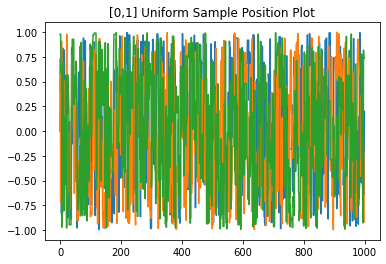

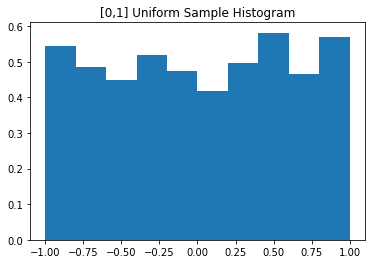

In [0]:
np.random.seed(0)
total_num_sample = 1000
def f(x):
  return ((x[0]<1) * (x[0]>-1)).reshape(-1)
gmh = Gibbs_with_Metropolis_Hastings(np.zeros((2,3)), f, total_num_sample)
sample = np.zeros((total_num_sample, 2, 3))
cnt = 0
for i in gmh:
    sample[cnt] = i
    cnt += 1

plt.plot(sample[:,0,0])
plt.plot(sample[:,0,1])
plt.plot(sample[:,0,2])

plt.title("[0,1] Uniform Sample Position Plot")
plt.show()
plt.hist(sample[:,0,:].reshape(-1), density=True)

plt.title("[0,1] Uniform Sample Histogram")
plt.show()

# Second Approach, Gibbs

In [0]:
# Testing distributed data
np.random.seed(0)
k_scale, theta_scale = 0.2, 0.2
k_init,theta_init = 1/k_scale,1/theta_scale
prior = lambda x: int((0.001 <= x[0]*k_scale <= 10)*(0.001 <= x[1]*theta_scale <= 20))
L_vec = lambda x: L2(x[0]*k_scale, x[1]*theta_scale, timepoints, timediff)*prior(x)
total_num_sample = 20000
start_param = np.asarray([k_init,theta_init], dtype=np.float64).repeat(1).reshape(2, -1)
gmh = Gibbs_with_Metropolis_Hastings(start_param, L_vec, total_num_sample, is_log=True)
sample = np.zeros((total_num_sample, 2, 1))
count = 0
for i in gmh.gen(1, 100, True):
  sample[count] = i
  count += 1
k_dist = sample[:,0,:].reshape(-1)*k_scale
theta_dist = sample[:,1,:].reshape(-1)*theta_scale
plt.hist(k_dist, bins = 100, density=True)
plt.title("k distribution")
plt.show()
plt.hist(theta_dist, bins = 100, density=True)
plt.title("Theta distribution")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log


KeyboardInterrupt: ignored

In [0]:
fig, ax = plt.subplots(2, 2)
ax[0,0].hist(k_dist, density=True, bins=30)
ax[0,0].set_title("k distribution")
ax[0,1].hist(theta_dist, density=True, bins=30)
ax[0,1].set_title("Theta distribution")
ax[1,0].plot(k_dist)
ax[1,0].set_title("k distribution")
ax[1,1].plot(theta_dist)
ax[1,1].set_title("Theta distribution")
fig.tight_layout() 
plt.show()


# Parameter search with Gibbs Sampling

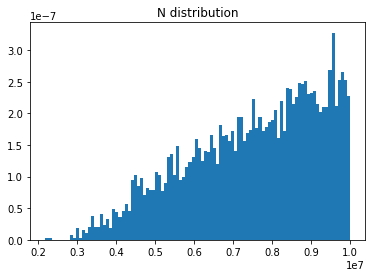

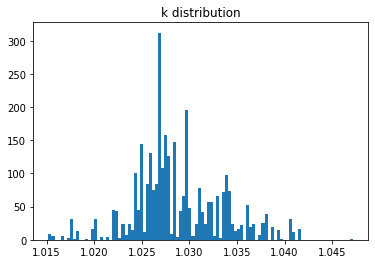

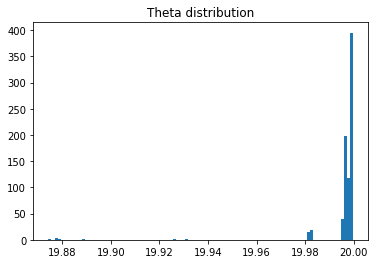

In [0]:
np.random.seed(0)
n_scale, k_scale, theta_scale = 500000, 0.2, 0.5
n_init,k_init,theta_init = 2000000/n_scale, 1.1/k_scale,3/theta_scale
prior = lambda x: int((max(infected) <= x[0]*n_scale <= 10000000)*(0.01 <= x[1]*k_scale <= 10)*(0.01 <= x[2]*theta_scale <= 20))
L_vec = lambda x: L(x[0]*n_scale, x[1]*k_scale, x[2]*theta_scale, test_inf, test_new_inf)*prior(x)
total_num_sample = 5000
start_param = np.asarray([n_init,k_init,theta_init], dtype=np.float64).repeat(1).reshape(3, -1)
gmh = Gibbs_with_Metropolis_Hastings(start_param, L_vec, total_num_sample, is_log=True)
sample = np.zeros((total_num_sample, 3, 1))
count = 0
for i in gmh.gen(1, 100, True):
  sample[count] = i
  count += 1
N_dist = sample[:,0,:].reshape(-1)*n_scale
k_dist = sample[:,1,:].reshape(-1)*k_scale
theta_dist = sample[:,2,:].reshape(-1)*theta_scale
plt.hist(N_dist, bins = 100, density=True)
plt.title("N distribution")
plt.show()
plt.hist(k_dist, bins = 100, density=True)
plt.title("k distribution")
plt.show()
plt.hist(theta_dist, bins = 100, density=True)
plt.title("Theta distribution")
plt.show()

In [0]:
# np.random.seed(0)
# n_scale, k_scale, theta_scale = 500000, 0.1, 0.1
# n_init,k_init,theta_init = 2000000/n_scale, 1.1/k_scale,3/theta_scale
# prior = lambda x: (0.01 <= x[0]*k_scale <= 10)*(0.01 <= x[1]*theta_scale <= 20)
# L_vec = lambda x: L(10000000, x[0]*k_scale, x[1]*theta_scale, test_inf, test_new_inf)*prior(x)
# total_num_sample = 50000
# start_param = np.asarray([k_init,theta_init], dtype=np.float64).repeat(1).reshape(2, -1)
# gmh = Gibbs_with_Metropolis_Hastings(start_param, L_vec, total_num_sample, is_log=False)
# sample = np.zeros((total_num_sample, 2, 1))
# count = 0
# for i in gmh.gen(1, 100, True):
#   sample[count] = i
#   count += 1
# #N_dist = sample[:,0,:].reshape(-1)*n_scale
# k_dist = sample[:,0,:].reshape(-1)*k_scale
# theta_dist = sample[:,1,:].reshape(-1)*theta_scale
# #plt.hist(N_dist, bins = 100, density=True)
# #plt.title("N distribution")
# #plt.show()
# plt.hist(k_dist, bins = 100, density=True)
# plt.title("k distribution")
# plt.show()
# plt.hist(theta_dist, bins = 100, density=True)
# plt.title("Theta distribution")
# plt.show()


In [0]:
fig, ax = plt.subplots(2, 3)
ax[0,0].hist(N_dist, density=True, bins=30)
ax[0,0].set_title("N distribution")
ax[0,1].hist(k_dist, density=True, bins=30)
ax[0,1].set_title("k distribution")
ax[0,2].hist(theta_dist, density=True, bins=30)
ax[0,2].set_title("Theta distribution")
ax[1,0].plot(N_dist)
ax[1,0].set_title("N distribution")
ax[1,1].plot(k_dist)
ax[1,1].set_title("k distribution")
ax[1,2].plot(theta_dist)
ax[1,2].set_title("Theta distribution")
fig.tight_layout() 
plt.show()

In [0]:
print(theta_dist)

In [0]:
print(sample.shape)
print(np.var(sample, axis=0))

In [0]:

print(np.var(sample))